In [3]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import SimpleController, OpenController, BaseController
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()


In [4]:
def plot_rollout(sim):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
    ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Lateral Acceleration")
    ax.set_title("Rollout")
    plt.show()

In [5]:
driving_model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)

ONNX Runtime is using GPU


In [6]:
controller = SimpleController()

In [27]:
from tqdm import tqdm

def execute_test(filename, controller, driving_model, plot=False):
    sim = TinyPhysicsSimulator(driving_model, filename, controller=controller, debug=False)
    cost = sim.rollout()
    if plot:
        plot_rollout(sim)
    return cost
    
def compare_with_baseline(driving_model, filename, baseline_controller, test_controller):
    baseline_cost = execute_test(filename, baseline_controller, driving_model, plot=True)
    cost = execute_test(filename, test_controller, driving_model, plot=True)
    print(baseline_cost, cost)

In [24]:
# Instantiate the env
import os

eval_env = DriverEnv(driving_model, controller, None, False, 0, ["data/00000.csv"])
log_dir = "/notebooks/comma/tmp/"
#log_dir = "/notebooks/comma/controls_challenge/tmp/"
stats_path = os.path.join(log_dir, "TRPO_Steering_vec_normalize.pkl")
#stats_path = os.path.join(log_dir, "model_checkpoints/rl_model_vecnormalize_280719_steps.pkl")
eval_env = make_vec_env(lambda: eval_env, n_envs=1)
eval_env = VecNormalize.load(stats_path, eval_env)
#  do not update them at test time
eval_env.training = False
# reward normalization is not needed at test time
eval_env.norm_reward = False
eval_env = VecFrameStack(eval_env, 10)

# Load the agent
model = TRPO.load(log_dir + "TRPO_Steering", env=eval_env)
#model = TRPO.load(log_dir + "model_checkpoints/rl_model_280719_steps", env=eval_env)

In [31]:
import pandas as pd

temp = pd.read_csv('data/00002.csv', sep=',')
goodController = BaseController2(eval_env, model, 20, temp)
#goodController = BaseController(booster, scaler, temp)

Retrieving cost for data/00000.csv: 73.61142271153338
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.     

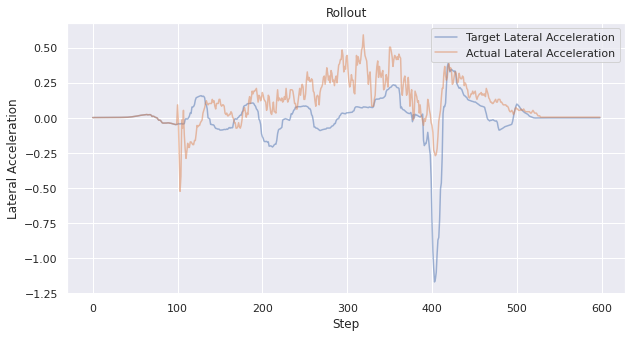

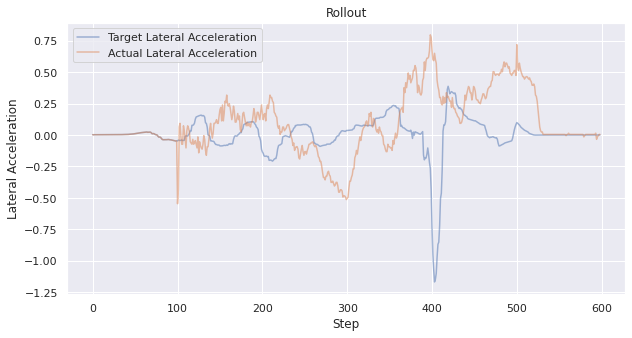

{'lataccel_cost': 4.609353730518906, 'jerk_cost': 25.893590692945118, 'total_cost': 48.94035934553965} {'lataccel_cost': 13.125651672297863, 'jerk_cost': 24.369957215462723, 'total_cost': 89.99821557695203}


In [116]:
compare_with_baseline(driving_model, "./data/00003.csv", controller, goodController)

In [32]:
# TRPO 2 Final without baseline cost
sim = TinyPhysicsSimulator(driving_model, "./data/00002.csv", controller=goodController, debug=False)
sim.rollout()

Cost for data/00000.csv is: {'lataccel_cost': 6.679554461158983, 'jerk_cost': 50.86428747202187, 'total_cost': 84.26205977781679}
-10.650637066283409
Retrieving cost for data/00000.csv: 73.61142271153338


{'lataccel_cost': 5.648043117818136,
 'jerk_cost': 30.165564715887573,
 'total_cost': 58.40578030497825}

In [23]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

class BaseController2:
    
    def __init__(self, env, model, start_idx, data):
        self.env = env
        self.model = model
        self.start_idx = start_idx
        self.data = data
        self.lstm_states = None
        # Episode start signals are used to reset the lstm states
        self.episode_starts = np.ones((1,), dtype=bool)
        self.observation = self.env.reset()
        print(self.observation)
        #for i in range(21, CONTROL_START_IDX):
            #action, self.lstm_states = self.model.predict(self.observation, state=self.lstm_states, episode_start=self.episode_starts, deterministic=True)
        #    action, _ = self.model.predict(self.observation, deterministic=True)
            #self.observation, _, dones, _ = self.env.step([[self.data.iloc[i]['steerCommand']]])
        #    self.observation, _, _, _ = self.env.step([[self.data.iloc[i]['steerCommand']]])
            #self.episode_starts = dones
            #self.observation = self.observation[0]
        print("----")
    
    def update(self, target_lataccel, current_lataccel, state):
        #action, self.lstm_states = self.model.predict(self.observation, state=self.lstm_states, episode_start=self.episode_starts, deterministic=True)
        action, _ = self.model.predict(self.observation, deterministic=True)
        self.observation, _, dones, _ = self.env.step([[action[0][0]]])
        #self.observation, _, dones, _ = self.env.step([[action[0]]])
        #self.observation = self.observation[0]
        #self.episode_starts = dones
        #self.obs, _, _, _, self.info = self.env.step(action)
        return action[0][0]
        #return action[0]

# RL

In [1]:
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 25.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
!pip install stable-baselines3 sb3-contrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 57.7 MB/s eta 0:00:00
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 245, in split_lines
    for 

In [8]:
from tqdm import tqdm
import pandas as pd
dfs = []
to_load = 1
for i in tqdm(range(to_load), total=to_load):
    num_str = str(i)
    while len(num_str) < 5:
        num_str = '0' + num_str
    try:
        temp = pd.read_csv(f'/notebooks/comma/controls_challenge/data/{num_str}.csv', sep=',')
    except:
        print(f'data/{num_str}.csv does not exist')
    dfs.append(temp)
df = pd.concat(dfs)
df['shifted_target'] = df['targetLateralAcceleration'].shift(1).fillna(0)
df.head()

100%|██████████| 1/1 [00:00<00:00, 56.41it/s]


,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand,shifted_target
0,0.0,33.770260,-0.017300,0.037470,1.003864,-0.329734,0.000000
1,0.1,33.763533,-0.039069,0.037006,1.049681,-0.335021,1.003864
2,0.2,33.755949,-0.067940,0.036543,1.056292,-0.332706,1.049681
3,0.3,33.758334,-0.022276,0.036579,1.051750,-0.336199,1.056292
4,0.4,33.752904,-0.052032,0.036652,1.059831,-0.352662,1.051750


In [7]:
df.describe()

,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand,shifted_target
count,299723.000000,299723.000000,299723.000000,299723.000000,299723.000000,50000.000000,299722.000000
mean,29.922360,23.085139,-0.004909,0.013851,0.021330,0.073060,0.021330
std,17.304623,9.554909,0.455884,0.026744,0.457033,0.257389,0.457034
min,0.000000,-0.100100,-4.006798,-0.094107,-10.557144,-1.611671,-10.557144
25%,14.900000,16.599068,-0.099260,-0.000298,-0.064849,-0.050803,-0.064849
50%,29.900000,25.877500,0.001353,0.017571,0.000756,0.088235,0.000756
75%,44.900000,30.790938,0.113135,0.030182,0.079848,0.209936,0.079848
max,60.100000,40.516050,4.572845,0.136141,4.074947,1.679604,4.074947


In [9]:
from typing import Callable
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [28]:
STEER_RANGE = [-2, 2]
CONTROL_START_IDX = 100
DEL_T = 0.1
LAT_ACCEL_COST_MULTIPLIER = 5.0
CONTEXT_LENGTH = 20
MAX_ACC_DELTA = 0.5

class MySimulator(TinyPhysicsSimulator):
    
    def __init__(self, model: TinyPhysicsModel, data_path: str, controller: BaseController, debug: bool = False) -> None:
        super().__init__(model, data_path, controller, debug)
        
    def sim_step(self, step_idx: int) -> None:
        pred = self.sim_model.get_current_lataccel(
          sim_states=self.state_history[-CONTEXT_LENGTH:],
          actions=self.action_history[-CONTEXT_LENGTH:],
          past_preds=self.current_lataccel_history[-CONTEXT_LENGTH:]
        )
        pred = np.clip(pred, self.current_lataccel - MAX_ACC_DELTA, self.current_lataccel + MAX_ACC_DELTA)
        if step_idx >= CONTROL_START_IDX:
            self.current_lataccel = pred
        else:
            self.current_lataccel = self.get_state_target(step_idx)[1]
        self.current_lataccel_history.append(self.current_lataccel)
        
    def control_step(self, step_idx: int, steer_action: float) -> None:
        if step_idx >= CONTROL_START_IDX and steer_action is not None:
            action = steer_action
        else:
            action = self.data['steer_command'].values[step_idx]
            if pd.isna(action):
                action = self.controller.update(self.target_lataccel_history[step_idx], self.current_lataccel, self.state_history[step_idx])
        action = np.clip(action, STEER_RANGE[0], STEER_RANGE[1])
        self.action_history.append(action)
        
    def step(self, steer_action=None) -> None:
        state, target = self.get_state_target(self.step_idx)
        self.state_history.append(state)
        self.target_lataccel_history.append(target)
        self.control_step(self.step_idx, steer_action)
        self.sim_step(self.step_idx)
        self.step_idx += 1
        
    def rollout(self) -> float:
        if self.debug:
            plt.ion()
            fig, ax = plt.subplots(4, figsize=(12, 14), constrained_layout=True)

        for _ in range(CONTEXT_LENGTH, len(self.data)):
            self.step()
            if self.debug and self.step_idx % 10 == 0:
                print(f"Step {self.step_idx:<5}: Current lataccel: {self.current_lataccel:>6.2f}, Target lataccel: {self.target_lataccel_history[-1]:>6.2f}")
                self.plot_data(ax[0], [(self.target_lataccel_history, 'Target lataccel'), (self.current_lataccel_history, 'Current lataccel')], ['Step', 'Lateral Acceleration'], 'Lateral Acceleration')
                self.plot_data(ax[1], [(self.action_history, 'Action')], ['Step', 'Action'], 'Action')
                self.plot_data(ax[2], [(np.array(self.state_history)[:, 0], 'Roll Lateral Acceleration')], ['Step', 'Lateral Accel due to Road Roll'], 'Lateral Accel due to Road Roll')
                self.plot_data(ax[3], [(np.array(self.state_history)[:, 1], 'v_ego')], ['Step', 'v_ego'], 'v_ego')
                plt.pause(0.01)

        if self.debug:
            plt.ioff()
            plt.show()
        return self.compute_cost()
        
    def reverse_step(self) -> None:
        self.step_idx -= 1
        self.current_lataccel_history.pop()
        self.current_lataccel = self.current_lataccel_history[-1]
        self.action_history.pop()
        self.action_history.pop()
        self.target_lataccel_history.pop()
        self.state_history.pop()

        
    def compute_cost(self, unit=False) -> dict:
        if unit:
            target = np.array(self.target_lataccel_history)[self.step_idx - 2:self.step_idx]
            pred = np.array(self.current_lataccel_history)[self.step_idx - 2:self.step_idx]
        else:
            target = np.array(self.target_lataccel_history)[CONTROL_START_IDX:]
            pred = np.array(self.current_lataccel_history)[CONTROL_START_IDX:]
            
        lat_accel_cost = np.mean((target - pred)**2) * 100
        jerk_cost = np.mean((np.diff(pred) / DEL_T)**2) * 100
            
        total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost
        return {'lataccel_cost': lat_accel_cost, 'jerk_cost': jerk_cost, 'total_cost': total_cost}

In [29]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random


class DriverEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["console"]}

    def __init__(self, driving_model, controller, filename=None, plot_result=False, start_at=0, filenames=None):
        super().__init__()
        self.action_space = spaces.Box(
            low = -1, high = 1, shape = (1,), dtype = np.float32
        )
        self.driving_model = driving_model
        self.physics_simulator = None
        self.data = None
        self.controller = controller
        self.filename = filename
        self.file_n = start_at
        self.plot_result = plot_result
        self.baseline_simulator = None
        self.filenames = filenames
        self.baselines = {}
        self.exploration_done = False
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(
            low=np.array([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]),
            high=np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]),
            shape=(16,),
            dtype=np.float32
        )
        
    def calculate_cost(self, target, pred, prev_current_lataccel):
        lat_accel_cost = (target - pred)**2 * 100
        jerk_cost = ((pred - prev_current_lataccel) / DEL_T)**2 * 100
            
        total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost
        return total_cost
    
    def update_array(array, newVal, limit=20):
        array = np.append(array, newVal)
        if len(array) > limit:
            array = np.delete(array, 0)
        return array

    def step(self, action):
        prev_current_lataccel = self.physics_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        state, lataccel = self.physics_simulator.get_state_target(self.physics_simulator.step_idx)
        act = action[0] * 2
        
        self.last_actions = update_array(self.last_actions, act)        
            
        self.physics_simulator.step(act)
        where_should_i_be = self.data.iloc[self.physics_simulator.step_idx - 1]['targetLateralAcceleration']
        
        terminated = self.physics_simulator.step_idx == len(self.physics_simulator.data)
        if terminated:
            next_state, next_lataccel = self.physics_simulator.get_state_target(self.physics_simulator.step_idx - 1)
            print(f"Cost for {self.filenames[self.file_n]} is: {self.physics_simulator.compute_cost()}")
            #_, baseline_next_lataccel = self.baseline_simulator.get_state_target(self.physics_simulator.step_idx - 1)
        else:
            next_state, next_lataccel = self.physics_simulator.get_state_target(self.physics_simulator.step_idx)
            #_, baseline_next_lataccel = self.baseline_simulator.get_state_target(self.physics_simulator.step_idx)
            
        #baseline_prev_current_lataccel = self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 2]
        #_, baseline_lataccel = self.baseline_simulator.get_state_target(self.physics_simulator.step_idx - 1)
        
        #baseline_current_lataccel = self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        #baseline_cost = self.calculate_cost(baseline_next_lataccel, baseline_current_lataccel, baseline_prev_current_lataccel)
            
        current_lataccel = self.physics_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        self.cum_error += next_lataccel - current_lataccel
        self.last_errors = update_array(self.last_errors, next_lataccel - current_lataccel)
        self.last_targets = update_array(self.last_targets, next_lataccel)
        baseline_action = (lataccel - prev_current_lataccel) * 0.3
        mean_actions = np.mean(self.last_actions)
        if terminated:
            observation = np.array(
                [next_state.v_ego, next_state.a_ego, next_state.roll_lataccel, 
                next_lataccel, current_lataccel,
                (next_lataccel - current_lataccel) * 0.3,
                abs(next_lataccel - current_lataccel), 
                abs(next_lataccel) - abs(current_lataccel), 
                mean_actions,
                (next_lataccel - current_lataccel) - self.prev_error,
                self.cum_error,
                (act - mean_actions) / mean_actions,
                np.std(self.last_actions),
                np.mean(self.last_errors),
                np.std(self.last_errors),
                np.mean(self.last_targets),
                np.std(self.last_targets)
            ]).astype(np.float32)
            if self.exploration_done:
                baseline_cost = self.baseline_simulator.compute_cost()['total_cost']
                actual_cost = self.physics_simulator.compute_cost()['total_cost']
            else:
                baseline_cost = self.baseline_simulator.compute_cost()['lataccel_cost']
                actual_cost = self.physics_simulator.compute_cost()['lataccel_cost']
            if self.plot_result:
                plot_rollout(self.physics_simulator)
            #reward = total_cost * -1 #  baseline_cost - total_cost
            reward = np.clip((baseline_cost - actual_cost), -15, np.inf)
            if reward > 0:
                self.exploration_done = True
                reward = 15
                if not self.exploration_done:
                    print("EXPLORATION DONE")
            self.rewards = np.append(self.rewards, reward)
            print(reward, len(self.rewards[self.rewards == 0]), np.mean(self.rewards))
            #upper = abs(baseline_action) * 1.2
            #lower = abs(baseline_action) * 0.8

            #if abs(act) >= lower and abs(act) <= upper:
            #    reward = 0
            #else:
            #    reward = abs(baseline_action - act) * -1
            return observation, reward, terminated, False, {}
        
        target = next_lataccel
        pred = current_lataccel
            
        if self.exploration_done:
            if abs(next_lataccel - current_lataccel) <= 0.1:
                reward = 0
            else:
                reward = abs(next_lataccel - current_lataccel)*-1
        
        else:
            upper = abs(baseline_action) * 1.35
            lower = abs(baseline_action) * 0.65

            if abs(act) >= lower and abs(act) <= upper:
                reward = 0
            else:
                reward = abs(baseline_action - act) * -1
        self.rewards = np.append(self.rewards, reward)

        observation = np.array([next_state.v_ego, next_state.a_ego, next_state.roll_lataccel, 
                                next_lataccel, current_lataccel,
                                (next_lataccel - current_lataccel) * 0.3,
                                abs(next_lataccel - current_lataccel), 
                                abs(next_lataccel) - abs(current_lataccel), 
                                np.mean(self.last_actions),
                                (target - pred) - self.prev_error,
                                self.cum_error,
                                (act - mean_actions) / mean_actions,
                                np.std(self.last_actions),
                                np.mean(self.last_errors),
                                np.std(self.last_errors),
                                np.mean(self.last_targets),
                                np.std(self.last_targets)
                               ]).astype(np.float32)
        self.prev_error = target - pred
        self.last_action = act
        truncated = False
        info = {}
            
        return observation, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        if self.filename is None:
            if self.filenames is None:
                #n_file = random.randint(0, 20000)
                n_file = self.file_n
                num_str = str(n_file)
                while len(num_str) < 5:
                    num_str = '0' + num_str
                filename = f'/notebooks/comma/controls_challenge/data/{num_str}.csv'
            else:
                filename = self.filenames[self.file_n]
            self.file_n += 1
            if not self.exploration_done:
                filename = self.filenames[0]
                self.file_n -= 1
        else:
            filename = self.filename
        if self.file_n >= 20_000 or (self.filenames is not None and self.file_n >= len(self.filenames)):
            self.file_n = 0
        self.data = pd.read_csv(filename, sep=',')
        self.cum_error = 0
        self.prev_error = 0
        self.last_actions = np.array([])
        self.last_errors = np.array([])
        self.last_targets = np.array([])
        self.rewards = np.array([])
        self.last_action = 0
        self.physics_simulator = MySimulator(self.driving_model, filename, controller=controller, debug=False)
        if self.filename is None: # or self.baseline_simulator is None:
            if filename in self.baselines: 
                self.baseline_simulator = self.baselines[filename]
                cost = self.baseline_simulator.compute_cost()
                print(f"Retrieving cost for {filename}: {cost['total_cost']}")
            else:
                self.baseline_simulator = TinyPhysicsSimulator(self.driving_model, filename, controller=controller, debug=False) #TinyPhysicsSimulator
                cost = self.baseline_simulator.rollout()
                print(f"Calculating cost for {filename}: {cost['total_cost']}")
                self.baselines[filename] = self.baseline_simulator
        for i in range(20, 99):
            self.physics_simulator.step(self.data.iloc[i]['steerCommand'])
        self.prev_cost = 0
        observation, _, _, _, info = self.step(np.array([self.data.iloc[99]['steerCommand']]).astype(np.float32))
        return observation, info

    def render(self):
        pass

    def close(self):
        pass

In [18]:
#TODO
# Provar posar act vs mean actions past. posar std de les ultimes 20 actions?
# Com ho fem per generalitzar? Agafem 100 fitxers? Agafem 1 i despres passem a 100? Agafem 1 només? Agafem 5?

In [24]:
import pickle

with open('top200_20k.pkl', 'rb') as handle:
    filenames = pickle.load(handle)
filenames = sorted(list(set(filenames + ['data/00000.csv', 'data/00001.csv', 'data/00002.csv', 'data/00003.csv', 'data/00004.csv', 'data/00005.csv'])))
sorted(filenames)

['data/00000.csv',
 'data/00001.csv',
 'data/00002.csv',
 'data/00003.csv',
 'data/00004.csv',
 'data/00005.csv',
 'data/00069.csv',
 'data/00094.csv',
 'data/00210.csv',
 'data/00240.csv',
 'data/00420.csv',
 'data/00504.csv',
 'data/00505.csv',
 'data/00522.csv',
 'data/00582.csv',
 'data/00622.csv',
 'data/00693.csv',
 'data/00705.csv',
 'data/00904.csv',
 'data/01002.csv',
 'data/01240.csv',
 'data/01269.csv',
 'data/01302.csv',
 'data/01346.csv',
 'data/01458.csv',
 'data/01646.csv',
 'data/01804.csv',
 'data/01931.csv',
 'data/02127.csv',
 'data/02157.csv',
 'data/02497.csv',
 'data/02503.csv',
 'data/02620.csv',
 'data/02710.csv',
 'data/02833.csv',
 'data/02894.csv',
 'data/02931.csv',
 'data/03067.csv',
 'data/03069.csv',
 'data/03136.csv',
 'data/03261.csv',
 'data/03339.csv',
 'data/03432.csv',
 'data/03494.csv',
 'data/03608.csv',
 'data/03693.csv',
 'data/03821.csv',
 'data/04037.csv',
 'data/04100.csv',
 'data/04132.csv',
 'data/04237.csv',
 'data/04249.csv',
 'data/04294

In [27]:
from stable_baselines3 import PPO, A2C, TD3, SAC # DQN coming soon
# SAC the best so far, then TD3, then PPO, then TRPO
# from sb3_contrib import QRDQN, TQC
from sb3_contrib import TRPO, RecurrentPPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import get_schedule_fn
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, StackedObservations, VecFrameStack
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

# Instantiate the env
checkpoint_callback = CheckpointCallback(save_freq=5e4, save_path='tmp/model_checkpoints/', save_vecnormalize=True)
env = DriverEnv(driving_model, None, None, False, 0, filenames)
env = make_vec_env(lambda: env, n_envs=1)
env = VecNormalize(env, norm_obs=True, norm_reward=True)
#env = VecFrameStack(env, 10)
# Define and Train the agent
#policy = RecurrentActorCriticPolicy(env.observation_space, env.action_space, get_schedule_fn(0.0003), normalize_images=False)
#model = TRPO("MlpPolicy", env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.001))
model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.0006))
model.policy.normalize_images = False
model.learn(total_timesteps=700_000, log_interval = 10, callback=[checkpoint_callback])

Using cuda device
Calculating cost for data/00000.csv: 73.61142271153338
Cost for data/00000.csv is: {'lataccel_cost': 162.14904540682838, 'jerk_cost': 2229.417498349554, 'total_cost': 3040.162725383696}
-15.0 39 -1.2938857034181543
Retrieving cost for data/00000.csv: 73.61142271153338
Cost for data/00000.csv is: {'lataccel_cost': 284.5693537426038, 'jerk_cost': 2254.860906538967, 'total_cost': 3677.707675251986}
-15.0 49 -1.2868287726336272
Retrieving cost for data/00000.csv: 73.61142271153338
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 500          |
|    ep_rew_mean          | -646         |
| time/                   |              |
|    fps                  | 156          |
|    iterations           | 10           |
|    time_elapsed         | 8            |
|    total_timesteps      | 1280         |
| train/                  |              |
|    approx_kl            | 0.0066724285 |
|    clip_fraction        |

In [26]:
# Don't forget to save the VecNormalize statistics when saving the agent
import os
log_dir = "/notebooks/comma/tmp/"
model.save(log_dir + "FinalRecurrentPPO2Finetuned_Steering")
stats_path = os.path.join(log_dir, "FinalRecurrentPPO2Finetuned_Steering_vec_normalize.pkl")
env.save(stats_path)

In [23]:
import os
from stable_baselines3 import PPO, A2C, TD3, SAC
from sb3_contrib import TRPO, RecurrentPPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import get_schedule_fn
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, StackedObservations, VecFrameStack
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

env = DriverEnv(driving_model, None, None, False, 0, filenames)
#log_dir = "/notebooks/comma/controls_challenge/tmp/"
log_dir = "/notebooks/comma/tmp/"
#stats_path = os.path.join(log_dir, "model_checkpoints/rl_model_vecnormalize_150000_steps.pkl")
stats_path = os.path.join(log_dir, "FinalRecurrentPPO2_Steering_vec_normalize.pkl")
env = make_vec_env(lambda: env, n_envs=1)
env = VecNormalize.load(stats_path, env)
#  do not update them at test time
env.training = True
# reward normalization is not needed at test time
env.norm_reward = True
env.norm_obs = True
#env = VecFrameStack(env, 10)

# Load the agent
#model = TRPO.load(log_dir + "model_checkpoints/rl_model_296179_steps", env=eval_env, learning_rate=0.0001, batch_size=256)
#model = TRPO.load(log_dir + "TRPO_Steering", env=env, learning_rate=0.0003, batch_size=256)
#model = RecurrentPPO.load(log_dir + "model_checkpoints/rl_model_150000_steps", env=env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.0003))
model = RecurrentPPO.load(log_dir + "FinalRecurrentPPO2_Steering", env=env, verbose=1, seed=42, batch_size=256, learning_rate=linear_schedule(0.0001))
model.policy.normalize_images = False

In [25]:
model.learn(total_timesteps=200_000, log_interval = 10)#, callback=[checkpoint_callback])

Calculating cost for data/00000.csv: 73.16825358175088
Cost for data/00000.csv is: {'lataccel_cost': 3.826559781849945, 'jerk_cost': 53.0506446320668, 'total_cost': 72.18344354131652}
EXPLORATION DONE
15 54 -0.14932543303663764
Retrieving cost for data/00000.csv: 73.16825358175088
Cost for data/00001.csv is: {'lataccel_cost': 2.9203516801937677, 'jerk_cost': 55.32938658673613, 'total_cost': 69.93114498770497}
EXPLORATION DONE
15 220 -0.09025027043765399
Calculating cost for data/00001.csv: 32.53745524041349
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 500          |
|    ep_rew_mean          | -60          |
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 10           |
|    time_elapsed         | 16           |
|    total_timesteps      | 1280         |
| train/                  |              |
|    approx_kl            | 0.0019946392 |
|    clip_frac